[0.03  0.032 0.034 0.036 0.038 0.04  0.042 0.044] m
This loop is actually running
This loop is actually running
This loop is actually running
This loop is actually running
This loop is actually running
This loop is actually running
This loop is actually running
This loop is actually running


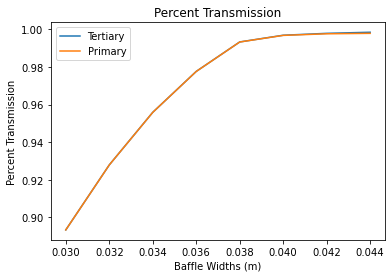

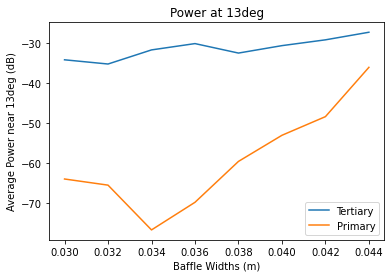

In [11]:
# Plot Baffle Radius vs % transmission and power at 13deg (Edge of Primary)
# Does not include trex

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import constants as const
import poppy
from poppy.wfe import WavefrontError
from astropy.units import cds

fwhm_ = np.sqrt(np.log(2)/297.4178) * u.m # 0.04827577473469725 m
lenslet_aperture = poppy.GaussianAperture(fwhm=fwhm_)
ff = 480*u.GHz # 420-540GHz
ll = const.c/ff
d_lenslet_lens = 24*u.cm

# Nominal radius=0.0381m
widths=u.Quantity(np.arange(0.03,0.045,0.002),u.m) #* u.m

# effective focal lengths of tertiary, secondary, primary
f_1 = 155 * u.cm
f_2 = 11940 * u.cm
f_3 = 19.2 * u.cm
tertiary_obj = poppy.QuadraticLens(f_lens=f_3)
secondary_obj = poppy.QuadraticLens(f_lens=f_2)
primary_obj = poppy.QuadraticLens(f_lens=f_1)

#Radii
coldstop = poppy.CircularAperture(radius=3.81*u.cm)
#baffle = poppy.CircularAperture(radius=3.874*u.cm) #This is iterated over 
tertiary_trunc = poppy.CircularAperture(radius=8*u.cm)
secondary_trunc = poppy.CircularAperture(radius=14.697*u.cm)
primary_trunc = poppy.CircularAperture(radius=40*u.cm)

# separations 
d_lens_3 = 33.06 * u.cm
d_3_2 = 86.562 * u.cm
d_IF = 19.2 * u.cm
d_2_1 = 104.995 * u.cm

# position of baffles above lens in inches
baffle_z_array = [0.350,
        0.700,
        1.050,
        2.150,
        2.500,
        2.850,
        3.950,
        4.300,
        4.650]

for i,baffle_z in enumerate(baffle_z_array):
    baffle_z_array[i] = (baffle_z*u.cds.inch).to(u.cm)

spill_power, trans_power, dB_radius = np.zeros((len(widths),1)), np.zeros((len(widths),1)), np.zeros((len(widths),1))
p_spill_power, p_trans_power, p_dB_radius = np.zeros((len(widths),1)), np.zeros((len(widths),1)), np.zeros((len(widths),1))

#w_idx=0
for w_idx,width in enumerate(widths):
    #width=width*u.m
    wf = poppy.FresnelWavefront(beam_radius=20*u.cm, wavelength=ll)
    
    #wf *= phase_gradient(4.5*u.mm,d_lenslet_lens,ff)

    wf *= lenslet_aperture
    
    ring = poppy.CircularAperture(radius=width)
    wf *= coldstop
    y, x = wf.coordinates()
    initial_power=np.sum(wf.intensity)

    wf.propagate_fresnel(0.35*u.cm)
    
    baffle = poppy.CircularAperture(radius=width) 
    for i,baffle_z in enumerate(baffle_z_array):
        if i==0:
            wf.propagate_fresnel(baffle_z)
        else:
            wf.propagate_fresnel(baffle_z-baffle_z_array[i-1])
        wf*=baffle

    wf.propagate_fresnel(d_lens_3-baffle_z_array[-1]) #propagate to center of tertiary

    temp = wf.intensity
    y, x = wf.coordinates()
    count = 0
    for m in np.arange(0,x.shape[0],dtype=int):
        for n in np.arange(0,x.shape[1],dtype=int):
            if (0.08)**2 < x[m,n]**2 + y[m,n]**2 :
                spill_power[w_idx] += temp[m,n]  
            elif (0.043444710048611554)**2 < x[m,n]**2 + y[m,n]**2 < (0.04455867644331863)**2 :
                dB_radius[w_idx] += temp[m,n]
                count += 1
                trans_power[w_idx] += temp[m,n]
            else:
                trans_power[w_idx] += temp[m,n]
    dB_radius[w_idx]=10*np.log10(dB_radius[w_idx]/count)-10*np.log10(np.max(temp))
    
    wf *= tertiary_trunc
    wf *= tertiary_obj
    wf.propagate_fresnel(d_3_2) # could insert IF baffle instead too
    
    wf *= secondary_trunc
    wf *= secondary_obj
    wf.propagate_fresnel(d_2_1)
    
    temp = wf.intensity
    y, x = wf.coordinates()
    count = 0
    for m in np.arange(0,x.shape[0],dtype=int):
        for n in np.arange(0,x.shape[1],dtype=int):
            if (0.4)**2 < x[m,n]**2 + y[m,n]**2 :
                p_spill_power[w_idx] += temp[m,n]  
            elif (0.39)**2 < x[m,n]**2 + y[m,n]**2 < (0.4)**2 :
                p_dB_radius[w_idx] += temp[m,n]
                count += 1
                p_trans_power[w_idx] += temp[m,n]
            else:
                p_trans_power[w_idx] += temp[m,n]
    p_dB_radius[w_idx]=10*np.log10(p_dB_radius[w_idx]/count)-10*np.log10(np.max(temp))
    
    #wf *= primary_obj
    
    #w_idx += 1     
            
#plt.plot(x[wf.intensity.shape[1]//2,1024:], 10*np.log10(wf.intensity[wf.intensity.shape[1]//2,1024:]))

plt.plot(widths, trans_power/initial_power, label="Tertiary")
plt.plot(widths, p_trans_power/initial_power, label="Primary")
plt.title("Percent Transmission")
plt.xlabel("Baffle Widths (m)")
plt.ylabel("Percent Transmission")
plt.legend()
plt.show()

plt.plot(widths,dB_radius,label="Tertiary")
plt.plot(widths,p_dB_radius,label="Primary")
plt.title("Power at 13deg")
plt.xlabel("Baffle Widths (m)")
plt.ylabel("Average Power near 13deg (dB)")
plt.legend()
plt.show()


In [4]:
# Trevor's phase gradient code
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import constants as const
import poppy
from poppy.wfe import WavefrontError

class phase_gradient(WavefrontError):
    def __init__(self,x_center_offset,d_z,freq, **kwargs):
        super(WavefrontError, self).__init__(name='Phase Gradient', **kwargs)
        
        self.x_center_offset=x_center_offset
        self.d_z=d_z
        self.freq=freq
    
    def get_opd(self, wave):
        """
        Parameters
        ----------
        wave : poppy.Wavefront (or float)
            Incoming Wavefront before this optic to set wavelength and
            scale, or a float giving the wavelength in meters
            for a temporary Wavefront used to compute the OPD.
        """

        y, x = self.get_coordinates(wave)*u.m  # in meters
        k=2*np.pi*self.freq/const.c

        opd = -((x.to(u.cm)+self.x_center_offset.to(u.cm))**2/(2*self.d_z)).to(u.m).value
        
        return opd
    

In [4]:
19.2*np.tan(12.749871*np.pi/180) #Calculating position of 'edge' region on tertiary

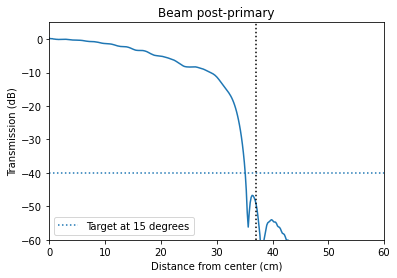

In [43]:
# Gives beam cuts with nominal baffle design

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import constants as const
import poppy
from poppy.wfe import WavefrontError
from astropy.units import cds

fwhm_ = np.sqrt(np.log(2)/297.4178) * u.m 
lenslet_aperture = poppy.GaussianAperture(fwhm=fwhm_)
ff = 480*u.GHz # 420-540GHz
ll = const.c/ff
d_lenslet_lens = 24*u.cm

widths=[0.041*u.m] #u.Quantity(np.arange(0.03,0.05,0.001),u.m) #* u.m

# effective focal lengths of tertiary, secondary, primary
f_1 = 155 * u.cm
f_2 = 11940 * u.cm
f_3 = 19.199 * u.cm
tertiary_obj = poppy.QuadraticLens(f_lens=f_3)
secondary_obj = poppy.QuadraticLens(f_lens=f_2)
primary_obj = poppy.QuadraticLens(f_lens=f_1)

#Radii
coldstop = poppy.CircularAperture(radius=3.81*u.cm)
baffle = poppy.CircularAperture(radius=3.874*u.cm) 
tertiary_trunc = poppy.CircularAperture(radius=8*u.cm)
secondary_trunc = poppy.CircularAperture(radius=14.697*u.cm)
primary_trunc = poppy.CircularAperture(radius=40*u.cm)


# separations 
d_lens_3 = 33.06 * u.cm
d_3_2 = 86.562 * u.cm
d_IF = 19.2 * u.cm
d_2_1 = 104.995 * u.cm

# position of baffles above lens in inches
baffle_z_array = [0.350,
        0.700,
        1.050,
        2.150,
        2.500,
        2.850,
        3.950,
        4.300,
        4.650]

for i,baffle_z in enumerate(baffle_z_array):
    baffle_z_array[i] = (baffle_z*u.cds.inch).to(u.cm)

w_idx=0
for width in widths:
   
    #Trevor uses 8.13
    wf = poppy.FresnelWavefront(beam_radius=10*u.cm, wavelength=ll) #npix=2048 etc 
    
    #wf *= phase_gradient(4.5*u.mm,d_lenslet_lens,ff)

    wf *= lenslet_aperture
    
    wf *= coldstop
    y, x = wf.coordinates()
    initial_power=np.sum(wf.intensity)

    wf.propagate_fresnel(0.35*u.cm)
        
    for i,baffle_z in enumerate(baffle_z_array):
        if i==0:
            wf.propagate_fresnel(baffle_z)
        else:
            wf.propagate_fresnel(baffle_z-baffle_z_array[i-1])
        wf*=baffle

    wf.propagate_fresnel(d_lens_3-baffle_z_array[-1]) #propagate to center of tertiary

    wf *= tertiary_trunc   
    wf *= tertiary_obj

    wf.propagate_fresnel(d_IF) 
    
    trex = poppy.CircularAperture(radius=4*u.cm)
    wf *= trex
    
    wf.propagate_fresnel(d_3_2-d_IF)
    
    wf *= secondary_trunc
    wf *= secondary_obj
    wf.propagate_fresnel(d_2_1)

    y, x = wf.coordinates()
    
    #wf *= primary_trunc
    #wf *= primary_obj
    
    w_idx += 1     
            
plt.plot(100*x[wf.intensity.shape[1]//2,1024:], 10*np.log10(wf.intensity[wf.intensity.shape[1]//2,1024:]))
plt.axhline(y=-40,label='Target at 15 degrees',linestyle=':')
plt.axvline(x=37,color='black',linestyle=':')
plt.xlabel('Distance from center (cm)')
#plt.xlabel('Distance (cm)')
plt.ylabel('Transmission (dB)')
plt.xlim((0,60))
plt.ylim((-60,5))
#plt.yscale('log')
plt.title('Beam post-primary')
plt.legend()
plt.show()



In [44]:
wf *= primary_obj
wf *= primary_trunc
wf.propagate_fresnel(150*u.m)

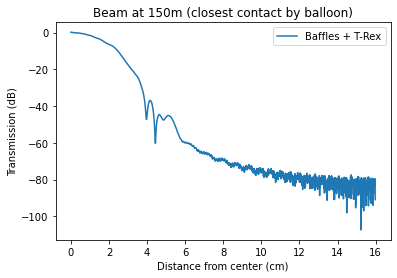

In [45]:
y_0, x_0 = wf.coordinates()
z_0 = wf.intensity
array_length = z_0.shape[0]
half_array_length = int(z_0.shape[0]/2)

plt.plot(x_0[half_array_length,half_array_length:],10*np.log10(z_0[half_array_length,half_array_length:]),
            label='Baffles + T-Rex')
         
plt.title('Beam at 150m (closest contact by balloon)')
plt.xlabel('Distance from center (cm)')
#plt.xlabel('Angle (deg)')
plt.ylabel('Transmission (dB)')
#plt.xlim((0,0.15))
#plt.ylim((-2,0))
#plt.yscale('log')
plt.legend()
plt.show()

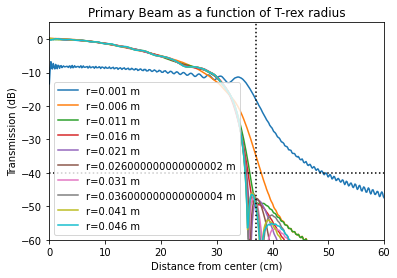

In [1]:
#This block will plot the beam at the primary given various Trex radii

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import constants as const
import poppy
from poppy.wfe import WavefrontError
from astropy.units import cds

fwhm_ = np.sqrt(np.log(2)/297.4178) * u.m 
lenslet_aperture = poppy.GaussianAperture(fwhm=fwhm_)
ff = 480*u.GHz # 420-540GHz
ll = const.c/ff
d_lenslet_lens = 24*u.cm

trradii=u.Quantity(np.arange(0.001,0.05,0.005),u.m)

# effective focal lengths of tertiary, secondary, primary
f_1 = 155 * u.cm
f_2 = 11940 * u.cm
f_3 = 19.199 * u.cm
tertiary_obj = poppy.QuadraticLens(f_lens=f_3)
secondary_obj = poppy.QuadraticLens(f_lens=f_2)
primary_obj = poppy.QuadraticLens(f_lens=f_1)

#Radii
coldstop = poppy.CircularAperture(radius=3.81*u.cm)
baffle = poppy.CircularAperture(radius=3.874*u.cm) 
tertiary_trunc = poppy.CircularAperture(radius=8*u.cm)
secondary_trunc = poppy.CircularAperture(radius=14.697*u.cm)
primary_trunc = poppy.CircularAperture(radius=40*u.cm)


# separations 
d_lens_3 = 33.06 * u.cm
d_3_2 = 86.562 * u.cm
d_IF = 19.2 * u.cm
d_2_1 = 104.995 * u.cm

# position of baffles above lens in inches
baffle_z_array = [0.350,
        0.700,
        1.050,
        2.150,
        2.500,
        2.850,
        3.950,
        4.300,
        4.650]

for i,baffle_z in enumerate(baffle_z_array):
    baffle_z_array[i] = (baffle_z*u.cds.inch).to(u.cm)

for trradius in trradii: 
    
    wf = poppy.FresnelWavefront(beam_radius=8.1*u.cm, wavelength=ll) 

    wf *= lenslet_aperture
    
    wf *= coldstop
    y, x = wf.coordinates()
    initial_power=np.sum(wf.intensity)

    wf.propagate_fresnel(0.35*u.cm)
        
    for i,baffle_z in enumerate(baffle_z_array):
        if i==0:
            wf.propagate_fresnel(baffle_z)
        else:
            wf.propagate_fresnel(baffle_z-baffle_z_array[i-1])
        wf*=baffle

    wf.propagate_fresnel(d_lens_3-baffle_z_array[-1]) #propagate to center of tertiary
   
    wf *= tertiary_obj
    wf *= tertiary_trunc

    wf.propagate_fresnel(d_IF) 
    
    trex = poppy.CircularAperture(radius=trradius)
    wf *= trex
    
    wf.propagate_fresnel(d_3_2-d_IF)
    
    wf *= secondary_obj
    wf *= secondary_trunc
    wf.propagate_fresnel(d_2_1)

    y, x = wf.coordinates()
    plt.plot(100*x[wf.intensity.shape[1]//2,1024:], 10*np.log10(wf.intensity[wf.intensity.shape[1]//2,1024:]),
            label="r="+str(trradius))

plt.xlabel('Distance from center (cm)')
plt.ylabel('Transmission (dB)')
plt.xlim((0,60))
plt.ylim((-60,5))
plt.title('Primary Beam as a function of T-rex radius')
plt.axhline(y=-40,color='black',linestyle=':')
plt.axvline(x=37,color='black',linestyle=':')
plt.legend()
plt.show()
    

In [17]:
# Uses nominal baffle design to generate NFS_3.1

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import constants as const
import poppy
from poppy.wfe import WavefrontError
from astropy.units import cds

fwhm_ = np.sqrt(np.log(2)/297.4178) * u.m 
lenslet_aperture = poppy.GaussianAperture(fwhm=fwhm_)
ff = 480*u.GHz # 420-540GHz
ll = const.c/ff

widths=[0.041*u.m] #u.Quantity(np.arange(0.03,0.05,0.001),u.m) #* u.m

#Radii
coldstop = poppy.CircularAperture(radius=3.81*u.cm)
baffle = poppy.CircularAperture(radius=3.874*u.cm) 


# separations 
d_lens_3 = 33.06 * u.cm

# position of baffles above lens in inches
baffle_z_array = [0.350,
        0.700,
        1.050,
        2.150,
        2.500,
        2.850,
        3.950,
        4.300,
        4.650]

for i,baffle_z in enumerate(baffle_z_array):
    baffle_z_array[i] = (baffle_z*u.cds.inch).to(u.cm)


#Trevor uses 8.13
wf = poppy.FresnelWavefront(beam_radius=10*u.cm, wavelength=ll) #npix=2048 etc 
    
#wf *= phase_gradient(4.5*u.mm,d_lenslet_lens,ff)

wf *= lenslet_aperture
    
wf *= coldstop

wf.propagate_fresnel(0.35*u.cm)
        
for i,baffle_z in enumerate(baffle_z_array):
    if i==0:
        wf.propagate_fresnel(baffle_z)
    else:
        wf.propagate_fresnel(baffle_z-baffle_z_array[i-1])
    wf*=baffle

#wf.propagate_fresnel(25 * u.cm - baffle_z_array[-1]) #propagate to center of tertiary

y, x = wf.coordinates()
E=np.sqrt(wf.intensity)
phase=wf.phase
ERe=np.multiply(E,np.cos(phase))
EIm=np.multiply(E,np.sin(phase))

xm=np.abs(x)<0.05
ym=np.abs(y)<0.05
mask=np.logical_and(xm,ym)

xfile = open("NFS_3.1_x.txt","w")
np.savetxt(xfile,x[mask])
xfile.close()

yfile = open("NFS_3.1_y.txt","w")
np.savetxt(yfile,y[mask])
yfile.close()

ERefile = open("NFS_3.1_ERe.txt","w")
np.savetxt(ERefile,ERe[mask])
ERefile.close()

EImfile = open("NFS_3.1_EIm.txt","w")
np.savetxt(EImfile,EIm[mask])
EImfile.close()

In [10]:
baffle_z_array[-1]

<Quantity 11.811 cm>

In [1]:
# Uses nominal baffle design to generate NFS_3.1.3 (50GHz), NFS_3.2 (100GHz)

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import constants as const
import poppy
from poppy.wfe import WavefrontError
from astropy.units import cds

fwhm_ = np.sqrt(np.log(2)/297.4178) * u.m 
lenslet_aperture = poppy.GaussianAperture(fwhm=fwhm_)
ff = 100*u.GHz # Band = 420-540GHz
ll = const.c/ff

widths=[0.041*u.m] #u.Quantity(np.arange(0.03,0.05,0.001),u.m) #* u.m

#Radii
coldstop = poppy.CircularAperture(radius=3.81*u.cm)
baffle = poppy.CircularAperture(radius=3.874*u.cm) 


# separations 
d_lens_3 = 33.06 * u.cm

# position of baffles above lens in inches
baffle_z_array = [0.350,
        0.700,
        1.050,
        2.150,
        2.500,
        2.850,
        3.950,
        4.300,
        4.650]

for i,baffle_z in enumerate(baffle_z_array):
    baffle_z_array[i] = (baffle_z*u.cds.inch).to(u.cm)


#Trevor uses 8.13
wf = poppy.FresnelWavefront(beam_radius=10*u.cm, wavelength=ll) #npix=2048 etc 
    
#wf *= phase_gradient(4.5*u.mm,d_lenslet_lens,ff)

wf *= lenslet_aperture
    
wf *= coldstop

wf.propagate_fresnel(0.35*u.cm)
        
for i,baffle_z in enumerate(baffle_z_array):
    if i==0:
        wf.propagate_fresnel(baffle_z)
    else:
        wf.propagate_fresnel(baffle_z-baffle_z_array[i-1])
    wf*=baffle

wf.propagate_fresnel(25 * u.cm - baffle_z_array[-1]) #propagate to NFS

y, x = wf.coordinates()
E=np.sqrt(wf.intensity)
phase=wf.phase
ERe=np.multiply(E,np.cos(phase))
EIm=np.multiply(E,np.sin(phase))

xm=np.abs(x)<0.05
ym=np.abs(y)<0.05
mask=np.logical_and(xm,ym)

xfile = open("NFS_3.2_x.txt","w")
np.savetxt(xfile,x[mask])
xfile.close()

yfile = open("NFS_3.2_y.txt","w")
np.savetxt(yfile,y[mask])
yfile.close()

ERefile = open("NFS_3.2_ERe.txt","w")
np.savetxt(ERefile,ERe[mask])
ERefile.close()

EImfile = open("NFS_3.2_EIm.txt","w")
np.savetxt(EImfile,EIm[mask])
EImfile.close()

In [2]:
sum(sum(mask))/2048**2

NameError: name 'mask' is not defined

In [19]:
np.max(x[mask])

0.0498046875

c:\users\siebe\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


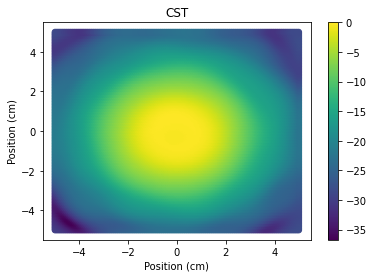

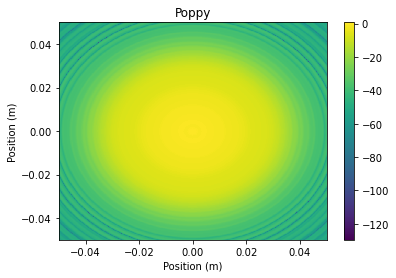

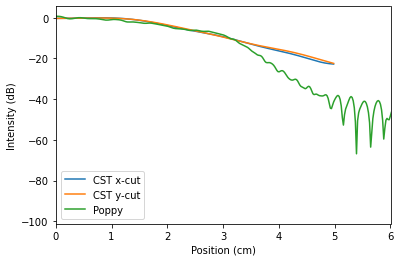

In [19]:
# Compares output of nominal baffle design to E_tin generated by NFS_3.1
# executed after running code that generates NFS_3.1.2

CSTout=np.loadtxt('EXCLAIM_Data/Goptics_run2/E_tin.txt')
CPow=CSTout[:,3]**2+CSTout[:,4]**2+CSTout[:,5]**2+CSTout[:,6]**2+CSTout[:,7]**2+CSTout[:,8]**2
Cx=CSTout[:,0]
Cy=CSTout[:,1]
Cz=CSTout[:,2]# the field monitor is in the xy-plane

fig, ax = plt.subplots()
scaling=10*np.log10(CPow)-max(10*np.log10(CPow))
c=ax.scatter(Cx,Cy,c=scaling)
fig.colorbar(c,ax=ax)
plt.title('CST')
plt.xlabel('Position (cm)')
plt.ylabel('Position (cm)')
plt.show()

plt.pcolormesh(x,y,10*np.log10(E**2))
plt.title('Poppy')
plt.xlim([-0.05, 0.05])
plt.ylim([-0.05, 0.05])
plt.colorbar() # colorbar applies to extreme values outside range plotted
plt.xlabel('Position (m)')
plt.ylabel('Position (m)')
plt.show()

xmask=(np.min(np.abs(Cx))==Cx)
ymask=(np.min(np.abs(Cy))==Cy)
plt.plot(Cy[xmask],scaling[xmask],label='CST x-cut')
plt.plot(Cx[ymask],scaling[ymask],label='CST y-cut')
plt.plot(100*x[wf.intensity.shape[1]//2,1024:], 10*np.log10(wf.intensity[wf.intensity.shape[1]//2,1024:]),label='Poppy')
plt.xlabel("Position (cm)")
plt.ylabel("Intensity (dB)")
plt.xlim([0, 6])
plt.legend(loc='lower left')
#plt.ylim([-0.05, 0.05])



In [6]:
print(np.sqrt((5.59085-83.7805)**2+(29.4098-36.8305)**2))
print(np.sqrt((83.7805-2.95326)**2+(36.8305-95.6859)**2))

78.54099665532964
99.98500305134566


MemoryError: Unable to allocate 64.0 MiB for an array with shape (4194304, 2) and data type float64

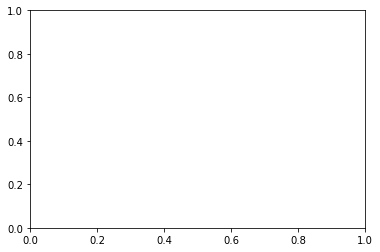

In [23]:
phase=wf.phase
plt.pcolormesh(x,y,phase)
#%plt.xlim([-0.05, 0.05])
#plt.ylim([-0.05, 0.05])

In [ ]:
# Compares output of nominal baffle design to E_tin generated by NFS_3.1
# executed after running code that generates NFS_3.1.2

CSTout=np.loadtxt('EXCLAIM_Data/Goptics_run2/E_tin.txt')
CPow=CSTout[:,3]**2+CSTout[:,4]**2+CSTout[:,5]**2+CSTout[:,6]**2+CSTout[:,7]**2+CSTout[:,8]**2
Cx=CSTout[:,0]
Cy=CSTout[:,1]
Cz=CSTout[:,2]# the field monitor is in the xy-plane

fig, ax = plt.subplots()
scaling=10*np.log10(CPow)-max(10*np.log10(CPow))
c=ax.scatter(Cx,Cy,c=scaling)
fig.colorbar(c,ax=ax)
plt.title('CST')
plt.xlabel('Position (cm)')
plt.ylabel('Position (cm)')
plt.show()

plt.pcolormesh(x,y,10*np.log10(E**2))
plt.title('Poppy')
plt.xlim([-0.05, 0.05])
plt.ylim([-0.05, 0.05])
plt.colorbar() # colorbar applies to extreme values outside range plotted
plt.xlabel('Position (m)')
plt.ylabel('Position (m)')
plt.show()

xmask=(np.min(np.abs(Cx))==Cx)
ymask=(np.min(np.abs(Cy))==Cy)
plt.plot(Cy[xmask],scaling[xmask],label='CST x-cut')
plt.plot(Cx[ymask],scaling[ymask],label='CST y-cut')
plt.plot(100*x[wf.intensity.shape[1]//2,1024:], 10*np.log10(wf.intensity[wf.intensity.shape[1]//2,1024:]),label='Poppy')
plt.xlabel("Position (cm)")
plt.ylabel("Intensity (dB)")
plt.xlim([0, 6])
plt.legend(loc='lower left')
#plt.ylim([-0.05, 0.05])
